In [2]:
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import ShuffleSplit
from sklearn.cross_validation import train_test_split
from sklearn import metrics as mt
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.preprocessing import OneHotEncoder
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_curve
from sklearn.pipeline import make_pipeline
sns.set_palette("husl")


c:\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [3]:
eopen=pd.read_csv('Data\email_opened_table.csv')
click=pd.read_csv('Data\link_clicked_table.csv')
email=pd.read_csv('Data\email_table.csv')

In [4]:
click['Clicked'] = 1
eopen['Opened'] = 1

* What percentage of users opened the email?
* what percentage clicked on the link within the email?

In [5]:
merged = email.merge(click, how='outer')
df = eopen.merge(merged, how='outer')
df = df.fillna(0)

In [6]:
print("Percentage of users opened the email {}%".format(df['Opened'].sum()*100/len(df)))
print("Percentage of clicked on the link within the email {}%".format(df['Clicked'].sum()*100/len(df)))

Percentage of users opened the email 10.345%
Percentage of clicked on the link within the email 2.119%


**Q. The VP of marketing thinks that it is stupid to send emails to a random subset and in a random way. Based on all the information you have about the emails that were sent, can you build a model to optimize in future email campaigns to maximize the probability of users clicking on the link inside the email?**

*Intuition*: The model requested would predict the column clicked and in turn opened. To understand the kind of model and feature to build, we need to perform EDA and preliminary Statistics analysis.


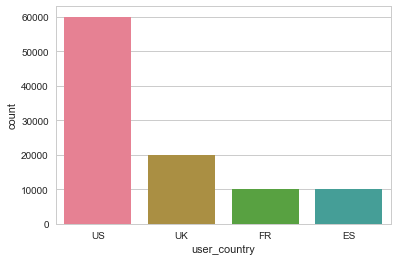

In [7]:
#Users according to country
sns.countplot(x="user_country", data=df)

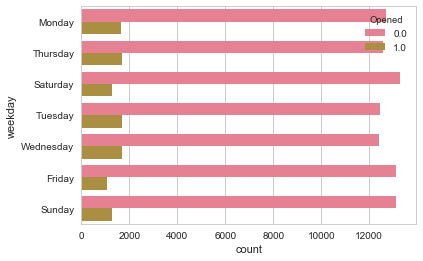

In [8]:
#Users according to weekday
sns.countplot(y="weekday",hue = "Opened", data=df)

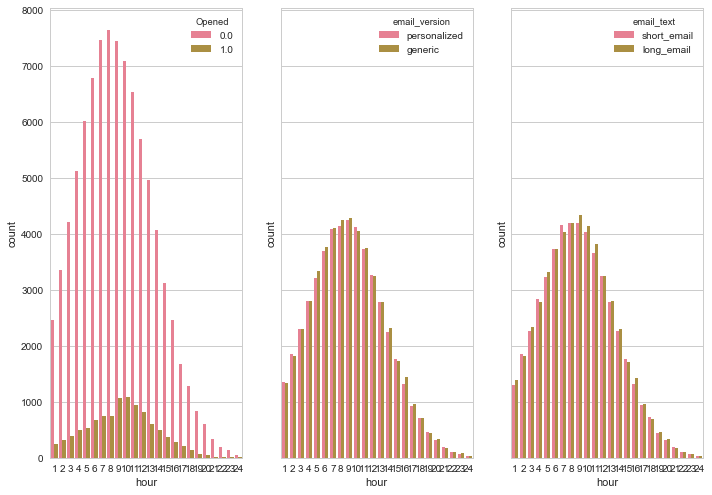

In [10]:
fig, (ax1, ax2,ax3) = plt.subplots(ncols=3, sharey=True)
fig.set_size_inches(11.7, 8.27)

sns.countplot(x="hour",hue = "Opened", data=df, ax = ax1)
sns.countplot(x="hour",hue = "email_version", data=df, ax = ax2)
sns.countplot(x="hour",hue = "email_text", data=df, ax = ax3)


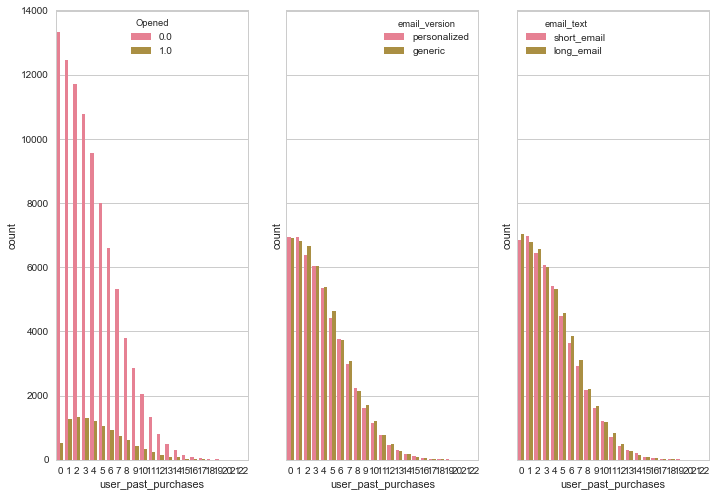

In [12]:
fig, (ax1, ax2,ax3) = plt.subplots(ncols=3, sharey=True)
fig.set_size_inches(11.7, 8.27)

sns.countplot(x="user_past_purchases",hue = "Opened", data=df, ax = ax1)
sns.countplot(x="user_past_purchases",hue = "email_version", data=df, ax = ax2)
sns.countplot(x="user_past_purchases",hue = "email_text", data=df, ax = ax3)


#### Some Facts about data:
     - Total email ID's : 10,000
     - Number of Unique Countires : 4, Maximum users in US
     - No visual difference in distribution of emails opened 
     - same number of personalised/generic emails sent

#### Chi-Square Testing

In [17]:
# Contigency Table representing Observed Table in %
click_text = pd.crosstab(index=df["email_text"], columns=df["Clicked"],  normalize='index').apply(lambda r: r*100, axis=1)
click_text
#Observation- No visible relation between clicked emails and email text

Clicked,0.0,1.0
email_text,,
long_email,98.146233,1.853767
short_email,97.612823,2.387177


In [35]:
from scipy.stats import chi2_contingency
def chisq_of_df_cols(df, c1, c2):
    ctsum = pd.crosstab(index=df[c1], columns=df[c2])
    return(chi2_contingency(ctsum))
chi2, p, dof, expected = chisq_of_df_cols(df, 'Clicked', 'email_text')
print("Chi value is {} and p-value is {}".format(chi2,p))

Chi value is 34.03743212010791 and p-value is 5.406196945274225e-09


Observation:
* Chi-squared tests provide a way to investigate differences in the distributions of categorical variables with the same categories and the dependence between categorical variables.
* As the p-value is less than 0.05, we can conclude that the variables are dependent. 
* Examining the pattern of numbers it is noted that more emails whether long or short emails choose not to click them.

*Note*: The degrees of freedom for a test of independence equals the product of the number of categories in each variable minus 

In [55]:
from itertools import combinations
L = ['email_text', 'email_version', 'weekday', 'user_country',  'Clicked']
tup = [(comb) for comb in combinations(L, 2)]
row = []
for t in tup:
    result = chisq_of_df_cols(df,t[0], t[1])
    if result[1]>0.05:
        r = "accept Null"
    else:
        r = "Reject Null"
    row.append(pd.Series({'Var1': t[0], 'Var2': t[1], 'chi2': result[0], 'p': result[1], 'Result': r}))
Chi_result = pd.DataFrame(row)


In [56]:
Chi_result

,Result,Var1,Var2,chi2,p
0,accept Null,email_text,email_version,0.006921,9.336979e-01
1,accept Null,email_text,weekday,3.865520,6.948693e-01
2,accept Null,email_text,user_country,0.700005,8.732028e-01
3,Reject Null,email_text,Clicked,34.037432,5.406197e-09
4,Reject Null,email_version,weekday,13.481748,3.599263e-02
5,accept Null,email_version,user_country,1.017662,7.969783e-01
6,Reject Null,email_version,Clicked,177.562629,1.650505e-40
7,accept Null,weekday,user_country,14.308473,7.087722e-01
8,Reject Null,weekday,Clicked,103.230664,5.310038e-20
9,Reject Null,user_country,Clicked,204.082662,5.533103e-44


#### Anova Tests

In [74]:
df.head()

,email_id,Opened,email_text,email_version,hour,weekday,user_country,user_past_purchases,Clicked
0,284534,1.0,short_email,personalized,7,Monday,US,6,1.0
1,609056,1.0,short_email,personalized,2,Thursday,US,6,1.0
2,220820,1.0,short_email,personalized,8,Monday,UK,4,1.0
3,905936,1.0,short_email,generic,14,Saturday,UK,3,1.0
4,164034,1.0,long_email,personalized,2,Thursday,US,11,1.0


c:\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


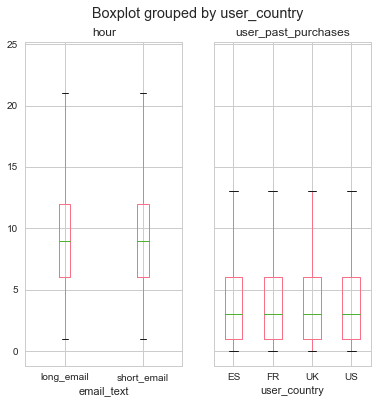

In [75]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
fig.set_size_inches(6, 6)
df.boxplot('hour', by='email_text', ax= ax1)
df.boxplot('user_past_purchases', by='user_country', ax= ax2)

In [78]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

df_lm = ols('user_past_purchases ~ C(email_text) + C(user_country) + C(weekday) + C(Clicked)',data=df).fit()
print(sm.stats.anova_lm(df_lm, typ=2))


                       sum_sq       df            F         PR(>F)
C(email_text)    2.788606e+01      1.0     2.761191   9.657947e-02
C(user_country)  1.837732e+02      3.0     6.065550   4.009211e-04
C(weekday)       1.258783e+02      6.0     2.077346   5.239141e-02
C(Clicked)       1.148738e+04      1.0  1137.444399  5.990236e-248
Residual         1.009808e+06  99988.0          NaN            NaN


*Observations*
* email_text, weekday and User past purchase are dependent
* user_country,clicked and User Past Purchase are independent features
   

### Feature Engineering
To effectively understand which features effect the click through rate, I'll aggregate the *Clicked* values to calculate the Clicked Through Rate (CTR) 

In [142]:
def get_plot_ctr(feature, hue = None ):
    if len(feature) < 2:
        res = df.groupby(feature).mean()
        g = sns.factorplot(x= res.index, y="Clicked", data=res, size=6, kind="bar", palette="muted")
    else:
        res = df.groupby(feature).mean().reset_index(level=[0,1])
        g = sns.factorplot(x= feature[0], y="Clicked", hue = hue, data=res, size=6, kind="bar", palette="muted")
    g.despine(left=True)
    g.set_ylabels("Click Through Rate")



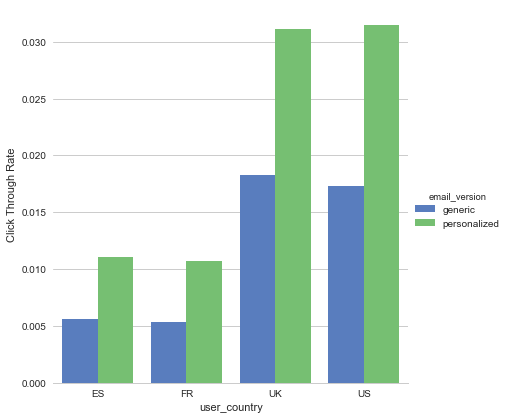

In [154]:
#Click Rate V/S User Country 
get_plot_ctr(["user_country","email_version"], hue = "email_version")

The personalised version of emails have a higher click through rate. We don't know if the emails send to users in non- English speaking country is in a different language or not. This might lead to a poor performance in English- Non- English speaking country.

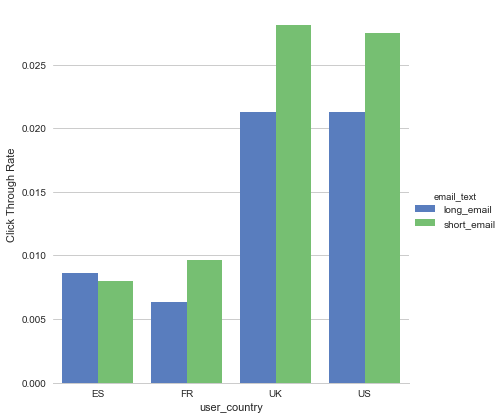

In [121]:
#Country
get_plot_ctr(["user_country","email_text"], hue = "email_text")


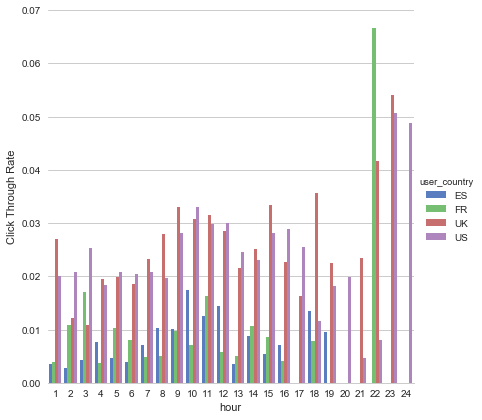

In [149]:
#Country
get_plot_ctr(["hour", "user_country"], hue = "user_country")
# Pe

No conclusive reasoning can be found in the above plot. Different countries have different timezones and emails should be sent accordingly. No such definitive pattern is visible right now

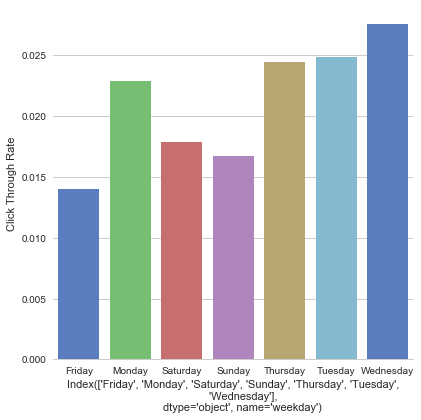

In [155]:
get_plot_ctr(["weekday"])


We are going to club Friday, Saturday and Sunday in *weekend* category and the rest of the days in *weekday*

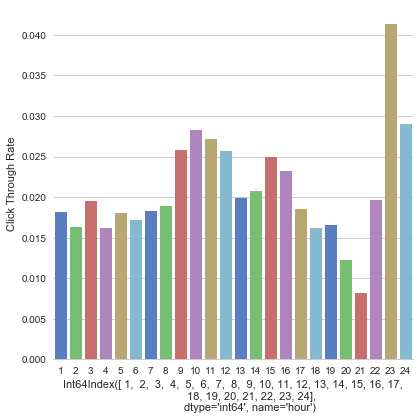

In [156]:
get_plot_ctr(["hour"])


In [ ]:
There seems no direct correlation between sending hour and 

In [150]:
df.head()

,email_id,Opened,email_text,email_version,hour,weekday,user_country,user_past_purchases,Clicked
0,284534,1.0,short_email,personalized,7,Monday,US,6,1.0
1,609056,1.0,short_email,personalized,2,Thursday,US,6,1.0
2,220820,1.0,short_email,personalized,8,Monday,UK,4,1.0
3,905936,1.0,short_email,generic,14,Saturday,UK,3,1.0
4,164034,1.0,long_email,personalized,2,Thursday,US,11,1.0
